In [1]:
"""
Let's...do accupedo.r but do it all in pandas without that fancy
intermediate table michigas...giggity...
"""

import numpy as np
import pandas as pd
import sqlite3 as lite
import datetime

WORK_DB_ = "work/Accupedo.db"

conn = lite.connect(WORK_DB_)


In [2]:
def get_aggregate_stats(conn):
    df = pd.read_sql_query("select * from diaries", conn)
    df.drop(columns=["lap", "lapsteps", "lapdistance", "lapcalories",
                     "lapsteptime", "distance", "calories", "speed", "pace",
                     "achievement"], inplace=True)

    df["ymdhm"] = 100*(100*(100*(100*df["year"]+df["month"])+df["day"])
                       + df["hour"])+df["minute"]
    df["ymd"] = 100*(100*df["year"]+df["month"])+df["day"]

    df.set_index("ymdhm")
    df.drop(columns=["_id"], inplace=True)

    df["del_steps"] = df["steps"] - df.shift(1)["steps"]
    df["del_time_min"] = (df["steptime"] - df.shift(1)["steptime"])/60000
    df["miia_steps"] = df["del_steps"].copy()
    df["miia_time_min"] = df["del_time_min"].copy()

    # steps reset at midnight so we need to drop the first interval of the day
    df.drop(df[df.del_steps<=0].index, inplace=True)

    df.drop(columns=["year", "month", "day", "hour", "minute", "steps",
                     "steptime"], inplace=True)

    match_not_fast = df[df["del_steps"]/df["del_time_min"] < 125].index
    df.loc[match_not_fast, "miia_steps"] = 0
    df.loc[match_not_fast, "miia_time_min"] = 0

    match_too_small = df[df["del_time_min"] < 1].index
    df.loc[match_too_small, "miia_steps"] = 0
    df.loc[match_too_small, "miia_time_min"] = 0
   
    df.drop(columns=["ymdhm"], inplace=True)
    df.dropna(inplace=True)

    redis = df.groupby("ymd").sum()
    # recompute pace as aggregate pace for group
    redis["pace"] = redis["del_steps"]/redis["del_time_min"]
    redis["miia_pace"] = redis["miia_steps"]/redis["miia_time_min"]

    return redis


          del_steps  del_time_min  miia_steps  miia_time_min        pace  \
ymd                                                                        
20180220    16136.0    136.724183      6755.0      49.454750  118.018624   
20180221    11982.0    100.715283      7952.0      59.715917  118.969034   
20180222    17145.0    136.014400     14185.0     107.393550  126.052830   
20180223    15049.0    122.059317      6924.0      52.320150  123.292514   
20180224    12212.0     99.959150      6952.0      51.653533  122.169906   
20180225    22446.0    194.752200      6519.0      47.226700  115.254154   
20180226    12417.0    103.567017      7137.0      52.028750  119.893383   

           miia_pace  
ymd                   
20180220  136.589509  
20180221  133.163827  
20180222  132.084283  
20180223  132.339070  
20180224  134.589050  
20180225  138.036323  
20180226  137.174159  
Days since zero: 91


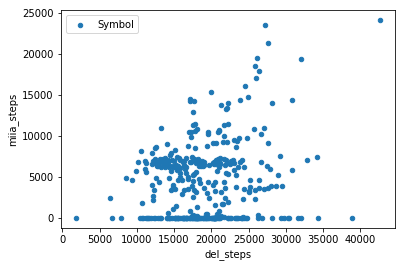

In [9]:
def show_graph(universe_frame):
    """Show our standard sharpe vs volatility scatter plot"""
    universe_frame[['miia_steps', 'del_steps']].plot(kind="scatter", x="del_steps",
                                                     y="miia_steps", label="Symbol")
    # plt.show(block=True)
    # plt.show()

result = get_aggregate_stats(conn)
print(result.tail(7))

show_graph(result.iloc[-365:])

last_zero_date = result[result["miia_steps"] == 0].index[-1]
since_then = result[result.index > last_zero_date]
days_since_zero = len(since_then.index)
print("Days since zero: {0}".format(days_since_zero))